In [12]:
import os
from importlib import reload

import numpy as np
import matplotlib.pyplot as plt

from sklearn.model_selection import train_test_split

import torch
import torchvision
from torchvision.datasets import ImageFolder
from torch.utils.data import DataLoader

from PIL import Image

import data
import models
import pvnet_utils
reload(pvnet_utils)

ROOT_DIR = "../dataset/LINEMOD"

%matplotlib inline

### Split files into test and train split

In [13]:
reload(data)
X_train, X_test, y_train, y_test = pvnet_utils.get_test_train_split(ROOT_DIR,['duck', 'cat', 'lamp'], 
                                                                    test_size=0.33, 
                                                                    random_state=2, 
                                                                    shuffle=True)

X = X_train[:1, :]
y = y_train[:1]

print(X)
print(y)

[['../dataset/LINEMOD/cat/JPEGImages/000122.jpg'
  '../dataset/LINEMOD/cat/mask/0122.png'
  '../dataset/LINEMOD/cat/labels/000122.txt']]
['cat']


### Create Dataset and Dataloader and visualize some batches

In [14]:
dataset = data.LineModReader((X_train, y_train))
dataloader = DataLoader(dataset, batch_size=8, shuffle=True)

### Visualize a batch

tensor(4)
tensor(1.)


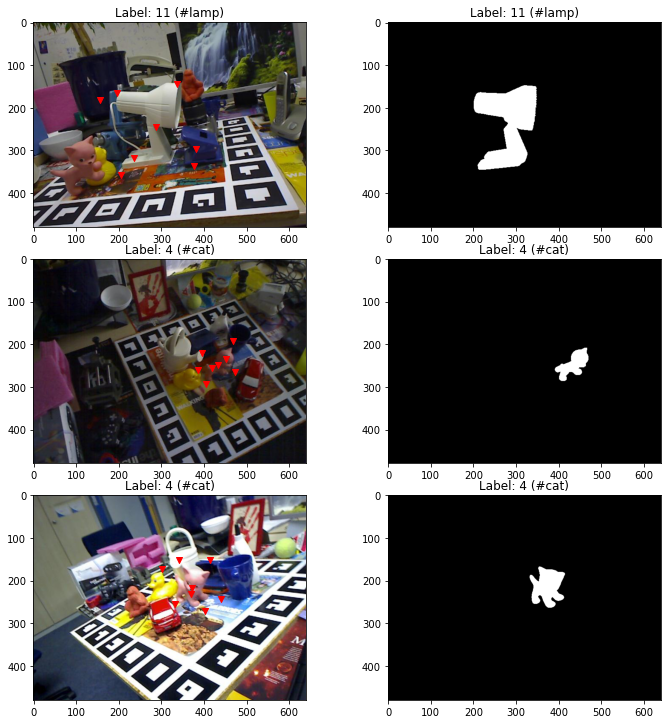

In [15]:
dataset.show_batch(3)

print(dataset[0]['class_label'])
print(dataset[0]['class_mask'].max())

/Users/nicholasmoy/miniconda3/envs/231a/lib/python3.9/site-packages/torch/nn/functional.py:3631: UserWarning: Default upsampling behavior when mode=bilinear is changed to align_corners=False since 0.4.0. Please specify align_corners=True if the old behavior is desired. See the documentation of nn.Upsample for details.
  warnings.warn(


torch.Size([13, 240, 320])
torch.Size([1, 240, 320])


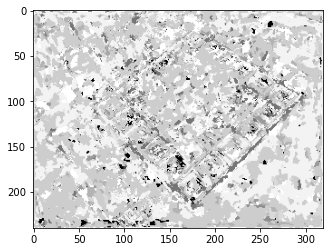

torch.Size([13, 240, 320])


In [16]:
from torchsummary import summary
reload(models)


# Test model
newmodel = models.PvNet(
    num_classes = 12,
    num_keypoints = 9,
    norm_layer = None,
    output_class = True,
    output_vector = False,
    pretrained = True
)
# summary(newmodel,(3,640,480))

# Outputs
print(torch.unsqueeze(dataset[0]['img'],0).size())

class_out = (newmodel(torch.unsqueeze(dataset[0]['img'],0)))['class'][0]
print(class_out.size())

# Get top class, scale by 12 for vis diff
classviz = torch.topk(class_out, 1, dim=0)[1] * 12
print(classviz.size())

plt.imshow(dataset.tensorToImage(classviz.type(torch.FloatTensor)),cmap='gray')
plt.show()


del newmodel
del dataset

# newmodel(dataset)

## Model Training

In [17]:
reload(data)
reload(models)
from torchsummary import summary

x_train, x_test, y_train, y_test = pvnet_utils.get_test_train_split(ROOT_DIR, ['duck', 'cat', 'lamp'], test_size=0.2, shuffle=False)

train_dataset = data.LineModReader((x_train, y_train))
test_dataset = data.LineModReader((x_test, y_test))

train_dataloader = DataLoader(train_dataset, batch_size=8, shuffle=True)
test_dataloader = DataLoader(test_dataset, batch_size=8, shuffle=True)

class_model = models.PvNet(
    num_classes = 12,
    num_keypoints = 9,
    norm_layer = None,
    output_class = True,
    output_vector = False,
    pretrained = True
)

summary(class_model,(640,480))

RuntimeError: Failed to run torchsummary. See above stack traces for more details. Executed layers up to: []

In [ ]:
import training
reload(training)
reload(pvnet_utils)

training.train(epochs= 1,
    train_data_loader = train_dataloader,
    test_data_loader = train_dataloader,
    device = 'cpu',
    model = class_model)

calculating class loss...
torch.Size([8, 480, 640])
torch.Size([8, 1, 1])
tensor([[13., 13., 13.,  ..., 13., 13., 13.],
        [13., 13., 13.,  ..., 13., 13., 13.],
        [13., 13., 13.,  ..., 13., 13., 13.],
        ...,
        [13., 13., 13.,  ..., 13., 13., 13.],
        [13., 13., 13.,  ..., 13., 13., 13.],
        [13., 13., 13.,  ..., 13., 13., 13.]])
Image 1 class label:6, Min_class: 6.0, Max_class:


RuntimeError: size mismatch (got input: [8, 13, 240, 320] , target: [8, 480, 640]